In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import LabelBinarizer
from collections import OrderedDict
from relate.network import SimpleNet

#### 常见的优化方法：

In [2]:
# 随机梯度下降法 Stochastic Gradient Descent
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

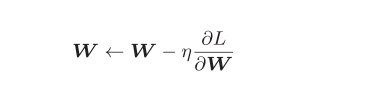
缺点：如果函数的形状非均向(anisotropic)，比如呈延伸状，搜索路径就会非常低效

In [4]:
# Momentum
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key,val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] -self.lr*grads[key]
            params[key] += self.v[key]


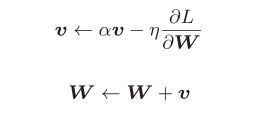

In [15]:
# AdaGrad AdaptiveGradient加入了学习率衰减(learning rate decay)的随机梯度下降算法
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key,val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr*grads[key]/(np.sqrt(self.h[key])+1e-7)

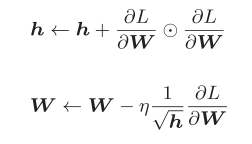
h 保存了以前的所有梯度值的平方和，在更新参数时通过乘以$\frac{1}{\sqrt{h}}$就可以调整学习的尺度
缺点： 学习越深入，更新的幅度就会越小，无止境的学习会导致更新量为零，完全不再更新

In [6]:
# Adam 融合了Momentum 和 AdaGrad的方法
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)   
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

In [9]:
# RMSprop
class RMSprop:
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [ ]:
# Nesterov
class Nesterov:
    """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]

#### 几种方法的比较：

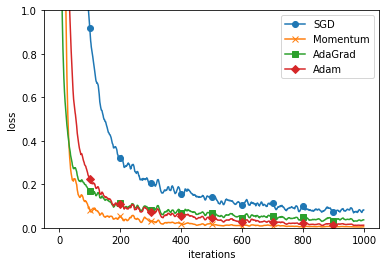

In [19]:
# 导入数据
digits = load_digits()
data = digits.data
target = digits.target
target = LabelBinarizer().fit_transform(target)
train_size = data.shape[0]
batch_size = 128
max_iter = 1000

# 模型准备
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = SimpleNet(input_size=64,hidden_size=50,output_size=10)
    train_loss[key] = []

# 开始训练
for i in range(max_iter):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = data[batch_mask]
    t_batch = target[batch_mask]
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    if i % 100 == 0:
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
def smooth_curve(x):
    # 用于使损失函数的图形变圆滑
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

# 绘制图形
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iter)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
print('', end='')